Saving H1N1 CASES.csv to H1N1 CASES (2).csv
Epoch 1/50
9/9 [==============================] - 3s 78ms/step - loss: 0.0038 - val_loss: 3.2241e-04
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 3.2015e-05
Epoch 3/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 4.8663e-05
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 1.0043e-06
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 1.1519e-05
Epoch 6/50
9/9 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 5.1409e-05
Epoch 7/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 1.5450e-05
Epoch 8/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 1.4206e-05
Epoch 9/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 5.7268e-06
Epoch 10/50
9/9 [==============================

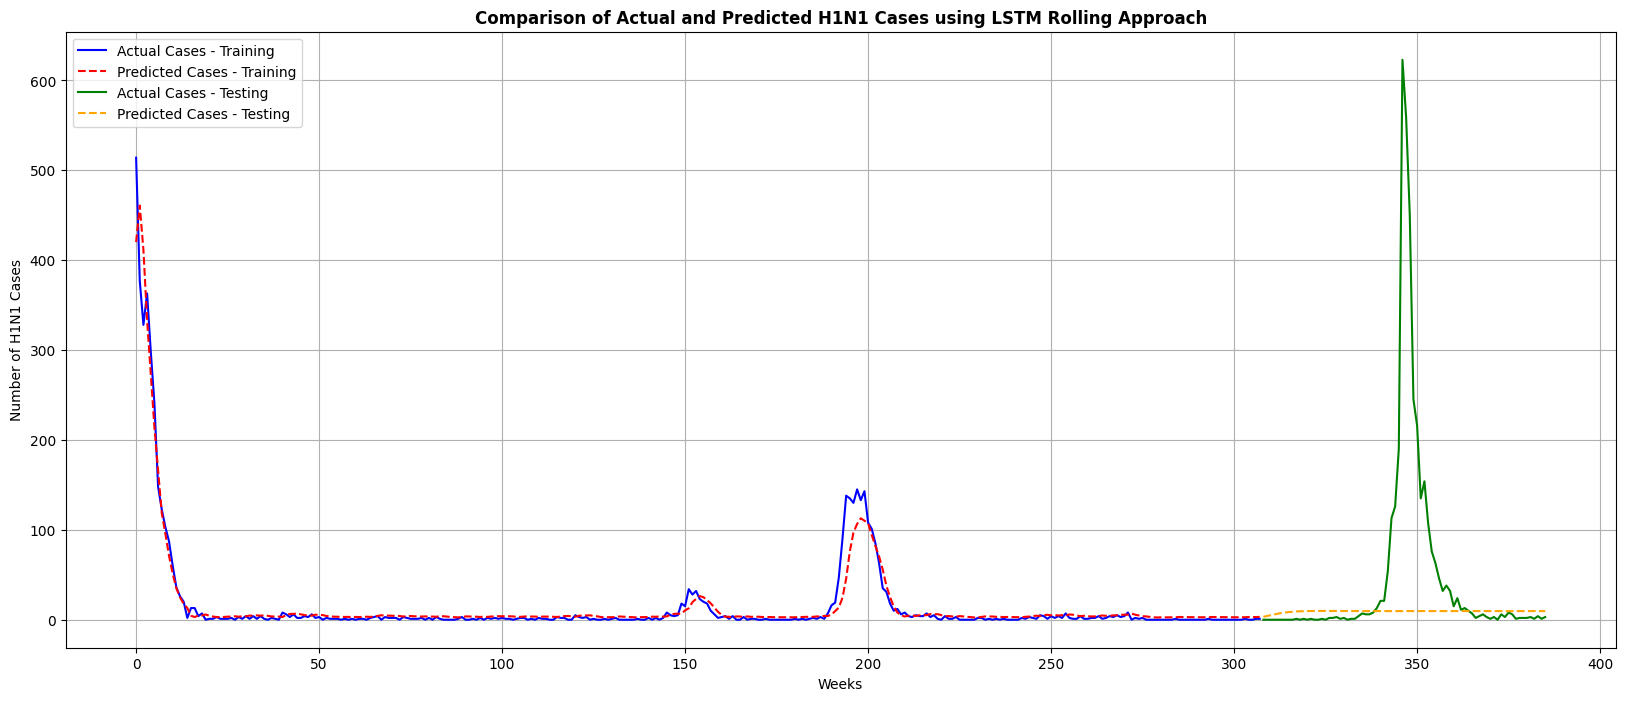

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# Upload and read the dataset
uploaded = files.upload()
filename = next(iter(uploaded))
data = pd.read_csv(filename)

# Renaming columns for clarity
data.columns = ['Week', 'Cases']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Cases'] = scaler.fit_transform(data[['Cases']])

# Prepare the sequences
window_size = 8

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences using the 'Cases' column
X, y = create_sequences(data['Cases'].values, window_size)

# Reshape for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the LSTM model
model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predict using both train and test set
train_predictions_normalized = model.predict(X_train)
test_predictions_normalized = []

# Rolling forecast for the test data
last_x = X_test[0]
for i in range(len(X_test)):
    pred = model.predict(last_x.reshape(1, window_size, 1))
    test_predictions_normalized.append(pred[0, 0])
    last_x = np.roll(last_x, -1)
    last_x[-1] = pred

# Convert all predictions back to the original scale
train_predictions = scaler.inverse_transform(train_predictions_normalized)
test_predictions = scaler.inverse_transform(np.array(test_predictions_normalized).reshape(-1, 1))
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(20, 8))
plt.plot(np.arange(len(y_train_original)), y_train_original, label='Actual Cases - Training', color='blue')
plt.plot(np.arange(len(y_train_original)), train_predictions, label='Predicted Cases - Training', linestyle='--', color='red')
plt.plot(np.arange(len(y_train_original), len(y_train_original) + len(y_test_original)), y_test_original, label='Actual Cases - Testing', color='green')
plt.plot(np.arange(len(y_train_original), len(y_train_original) + len(y_test_original)), test_predictions, label='Predicted Cases - Testing', linestyle='--', color='orange')
plt.title('Comparison of Actual and Predicted H1N1 Cases using LSTM Rolling Approach', fontweight='bold', fontsize='12')
plt.xlabel('Weeks')
plt.ylabel('Number of H1N1 Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming 'train_predictions' and 'test_predictions' contain the predicted values from your LSTM,
# and 'y_train_original' and 'y_test_original' contain the actual values.

# Calculate MAE for the training set
mae_train = mean_absolute_error(y_train_original, train_predictions)
# Calculate MAE for the testing set
mae_test = mean_absolute_error(y_test_original, test_predictions)

# Output the calculated MAEs
print("Training Mean Absolute Error:", mae_train)
print("Testing Mean Absolute Error:", mae_test)


Training Mean Absolute Error: 5.268843911684953
Testing Mean Absolute Error: 44.81179744158036
